[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moshi4/pyCirclize/blob/main/docs/circos_plot.ipynb)

In [1]:
# %pip install pycirclize 

## 1. Prokaryote

Dataset Repository:  
https://github.com/moshi4/pycirclize-data/tree/main/prokaryote

### 1-1. Enterobacteria phage

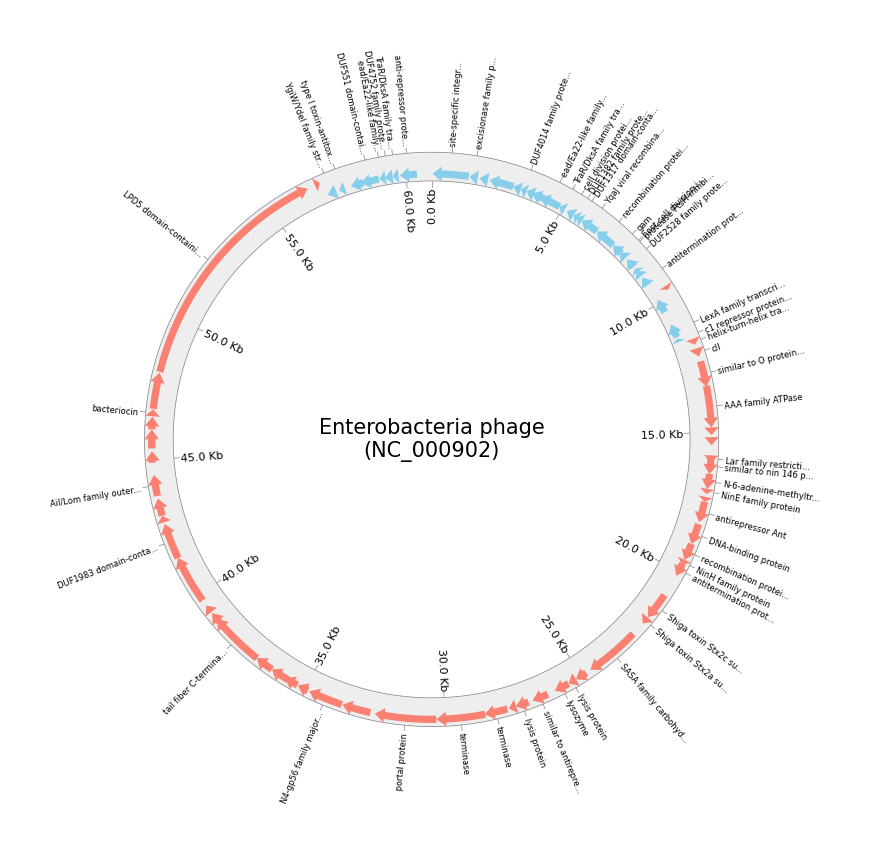

In [2]:
from pycirclize import Circos
from pycirclize.parser import Gff
from pycirclize.utils import load_prokaryote_example_file

# Load GFF file
gff_file = load_prokaryote_example_file("enterobacteria_phage.gff")
gff = Gff(gff_file)

circos = Circos(sectors={gff.name: gff.range_size})
circos.text("Enterobacteria phage\n(NC_000902)", size=15)

sector = circos.sectors[0]
cds_track = sector.add_track((90, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
# Plot forward CDS
cds_track.genomic_features(
    gff.extract_features("CDS", target_strand=1),
    plotstyle="arrow",
    r_lim=(95, 100),
    fc="salmon",
)
# Plot reverse CDS
cds_track.genomic_features(
    gff.extract_features("CDS", target_strand=-1),
    plotstyle="arrow",
    r_lim=(90, 95),
    fc="skyblue",
)
# Extract CDS product labels
pos_list, labels = [], []
for feat in gff.extract_features("CDS"):
    start, end = int(str(feat.location.end)), int(str(feat.location.start))
    pos = (start + end) / 2
    label = feat.qualifiers.get("product", [""])[0]
    if label == "" or label.startswith("hypothetical"):
        continue
    if len(label) > 20:
        label = label[:20] + "..."
    pos_list.append(pos)
    labels.append(label)
# Plot CDS product labels on outer position
cds_track.xticks(
    pos_list,
    labels,
    label_orientation="vertical",
    show_bottom_line=True,
    label_size=6,
    line_kws=dict(ec="grey"),
)
# Plot xticks & intervals on inner position
cds_track.xticks_by_interval(
    interval=5000,
    outer=False,
    show_bottom_line=True,
    label_formatter=lambda v: f"{v/ 1000:.1f} Kb",
    label_orientation="vertical",
    line_kws=dict(ec="grey"),
)

fig = circos.plotfig()

### 1-2. Escherichia coli

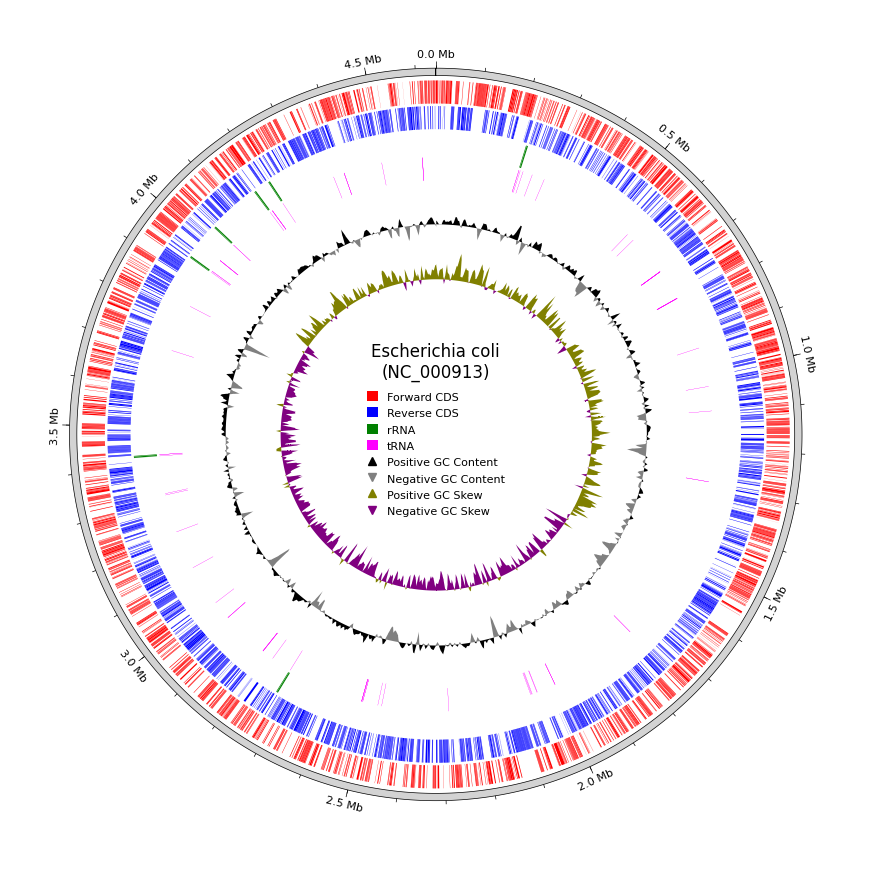

In [3]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load Genbank file
gbk_file = load_prokaryote_example_file("escherichia_coli.gbk.gz")
gbk = Genbank(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)
sector = circos.get_sector(gbk.name)

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

# Plot Forward CDS, Reverse CDS, rRNA, tRNA
f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="red")

r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

rrna_track = sector.add_track((76, 83), r_pad_ratio=0.1)
rrna_track.genomic_features(gbk.extract_features("rRNA"), fc="green")

trna_track = sector.add_track((69, 76), r_pad_ratio=0.1)
trna_track.genomic_features(gbk.extract_features("tRNA"), color="magenta", lw=0.1)

# Plot GC content
gc_content_track = sector.add_track((50, 65))

pos_list, gc_contents = gbk.calc_gc_content()
gc_contents = gc_contents - gbk.calc_genome_gc_content()
positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
abs_max_gc_content = np.max(np.abs(gc_contents))
vmin, vmax = -abs_max_gc_content, abs_max_gc_content
gc_content_track.fill_between(
    pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
)
gc_content_track.fill_between(
    pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
)

# Plot GC skew
gc_skew_track = sector.add_track((35, 50))

pos_list, gc_skews = gbk.calc_gc_skew()
positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
abs_max_gc_skew = np.max(np.abs(gc_skews))
vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
gc_skew_track.fill_between(
    pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="olive"
)
gc_skew_track.fill_between(
    pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="purple"
)

fig = circos.plotfig()

# Add legend
handles = [
    Patch(color="red", label="Forward CDS"),
    Patch(color="blue", label="Reverse CDS"),
    Patch(color="green", label="rRNA"),
    Patch(color="magenta", label="tRNA"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None"),
    Line2D([], [], color="olive", label="Positive GC Skew", marker="^", ms=6, ls="None"),
    Line2D([], [], color="purple", label="Negative GC Skew", marker="v", ms=6, ls="None"),
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)


### 1-3. Mycoplasma alvi

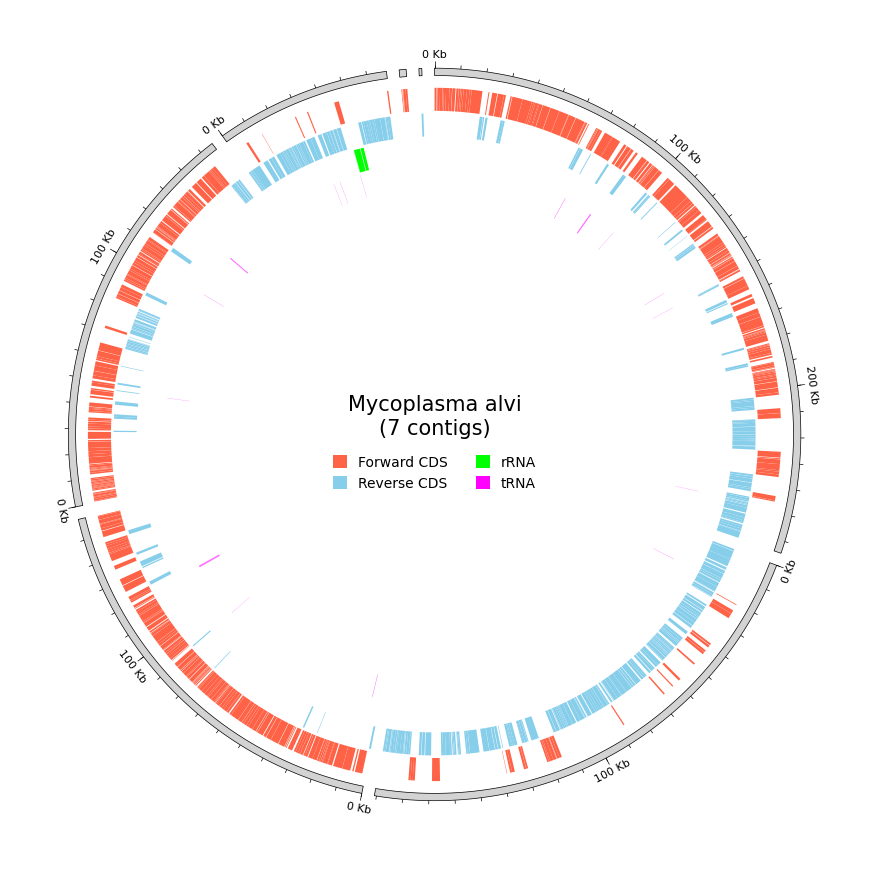

In [4]:
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file
from matplotlib.patches import Patch

# Case1. Load `GFF` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gff
gff_file = load_prokaryote_example_file("mycoplasma_alvi.gff")
parser = Gff(gff_file) 

# Case2. Load `Genbank` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gbk
# gbk_file = load_prokaryote_example_file("mycoplasma_alvi.gbk")
# parser = Genbank(gbk_file) 

# Get contig genome seqid & size, features dict
seqid2size = parser.get_seqid2size()
seqid2features = parser.get_seqid2features(feature_type=None)

circos = Circos(seqid2size, space=2)
circos.text(f"Mycoplasma alvi\n({len(circos.sectors)} contigs)", r=5, size=15)
for sector in circos.sectors:
    # Plot outer track
    outer_track = sector.add_track((98, 100))
    outer_track.axis(fc="lightgrey")
    major_interval = 100000
    minor_interval = int(major_interval / 10)
    if sector.size > minor_interval:
        outer_track.xticks_by_interval(major_interval, label_formatter=lambda v: f"{v / 1000:.0f} Kb")
        outer_track.xticks_by_interval(minor_interval, tick_length=1, show_label=False)

    # Plot forward/reverse CDS, rRNA, tRNA tracks
    f_cds_track = sector.add_track((88, 95), r_pad_ratio=0.1)
    r_cds_track = sector.add_track((81, 88), r_pad_ratio=0.1)
    rrna_track = sector.add_track((74, 81), r_pad_ratio=0.1)
    trna_track = sector.add_track((67, 74), r_pad_ratio=0.1)
    for feature in seqid2features[sector.name]:
        if feature.type == "CDS":
            if feature.strand == 1:
                f_cds_track.genomic_features([feature], fc="tomato")
            else:
                r_cds_track.genomic_features([feature], fc="skyblue")
        elif feature.type == "rRNA":
            rrna_track.genomic_features([feature], fc="lime")
        elif feature.type == "tRNA":
            trna_track.genomic_features([feature], fc="magenta")

fig = circos.plotfig()
_ = circos.ax.legend(
    handles=[
        Patch(color="tomato", label="Forward CDS"),
        Patch(color="skyblue", label="Reverse CDS"),
        Patch(color="lime", label="rRNA"),
        Patch(color="magenta", label="tRNA"),
    ],
    bbox_to_anchor=(0.5, 0.45),
    loc="center",
    ncols=2,
)

## 2. Eukaryote

### 2-1. Homo sapiens (hg38)

**hg38** data files are obtained from [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables).

Dataset Repository:  
https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38

#### 2-1-1. Ideograms

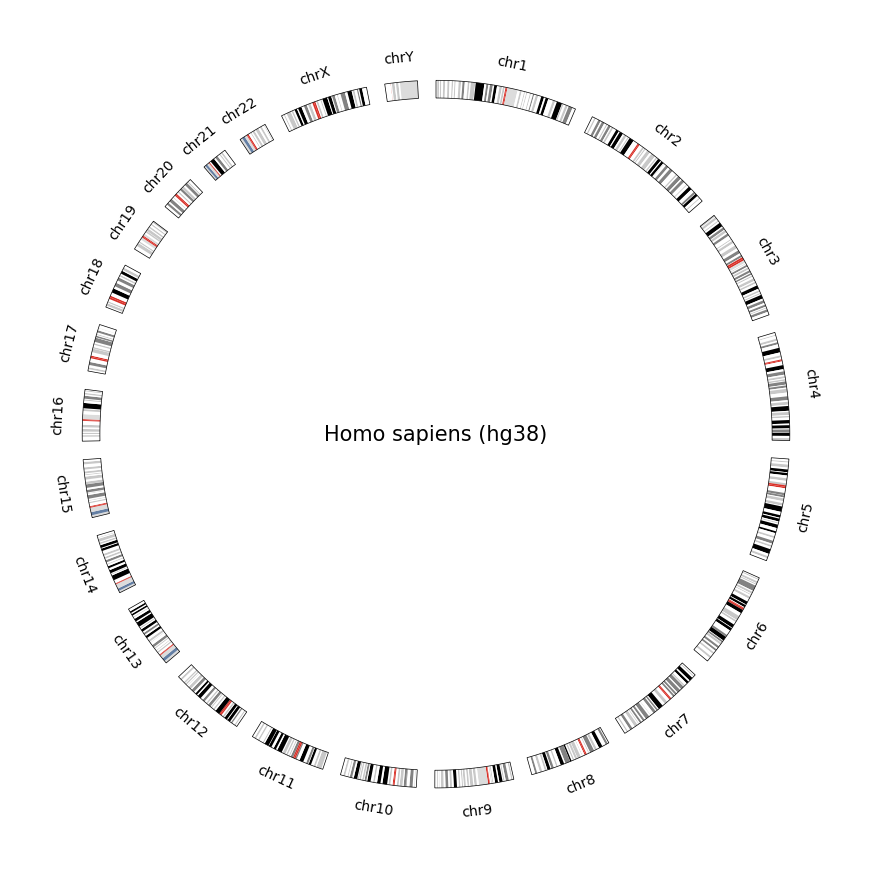

In [5]:
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file, cytoband_file, _ = load_eukaryote_example_dataset("hg38")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens (hg38)", size=15)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Plot chromosome name
for sector in circos.sectors:
    sector.text(sector.name, size=10)

fig = circos.plotfig()

#### 2-1-2. Segmental Dups Link

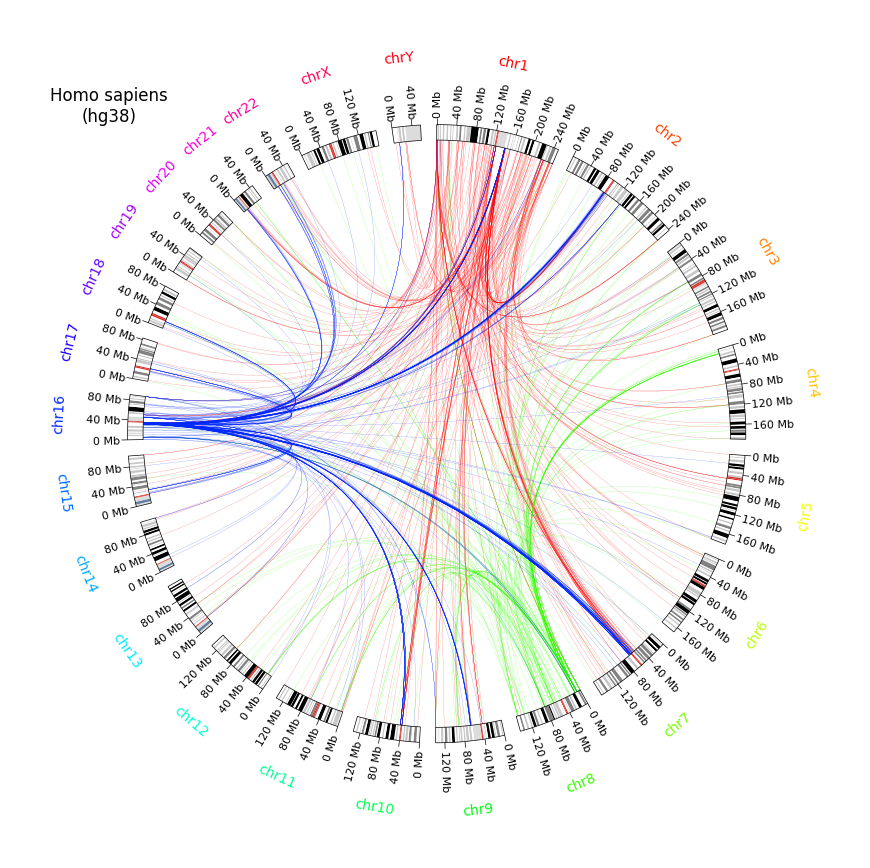

In [6]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color mapping
ColorCycler.set_cmap("hsv") 
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

# Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb",
    )

# Plot chromosome link
for link in chr_links:
    region1 = (link.query_chr, link.query_start, link.query_end)
    region2 = (link.ref_chr, link.ref_start, link.ref_end)
    color = chr_name2color[link.query_chr]
    if link.query_chr in ("chr1", "chr8", "chr16") and link.query_chr != link.ref_chr:
        circos.link(region1, region2, color=color)

fig = circos.plotfig()

### 2-2. Mus musculus (mm10)

**mm10** data files are obtained from [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables).

Dataset Repository:  
https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10

#### 2-2-1. Ideograms

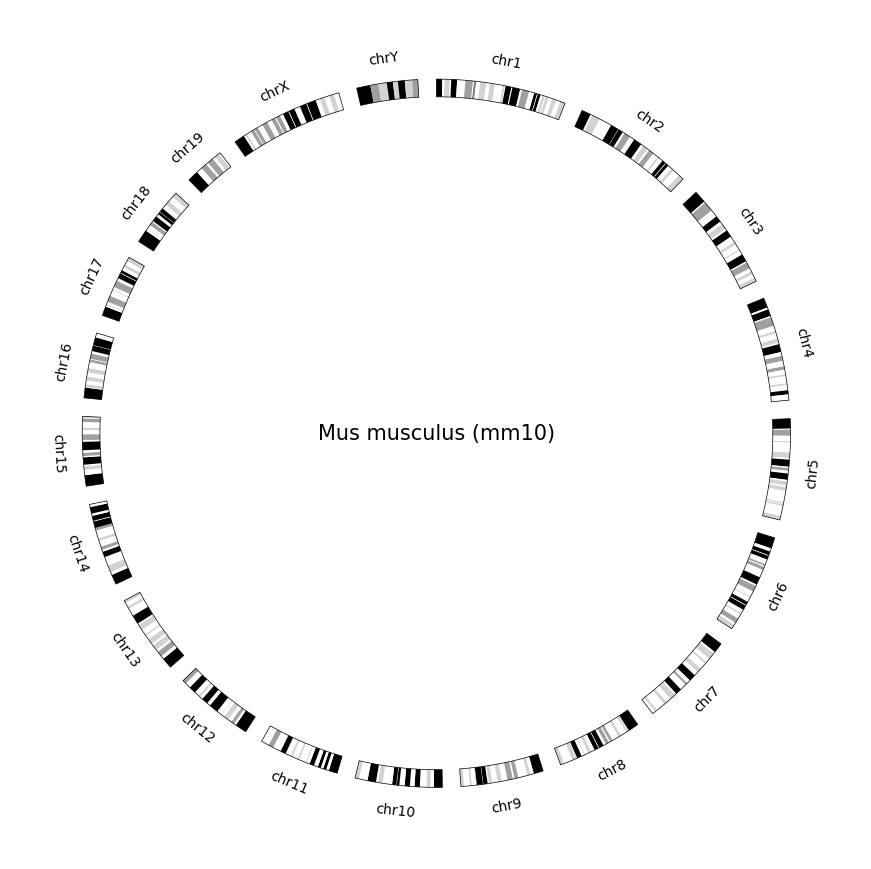

In [7]:
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

# Load mm10 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10)
chr_bed_file, cytoband_file, _ = load_eukaryote_example_dataset("mm10")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Mus musculus (mm10)", size=15)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Plot chromosome name
for sector in circos.sectors:
    sector.text(sector.name, size=10)

fig = circos.plotfig()

#### 2-2-2. Segmental Dups Link

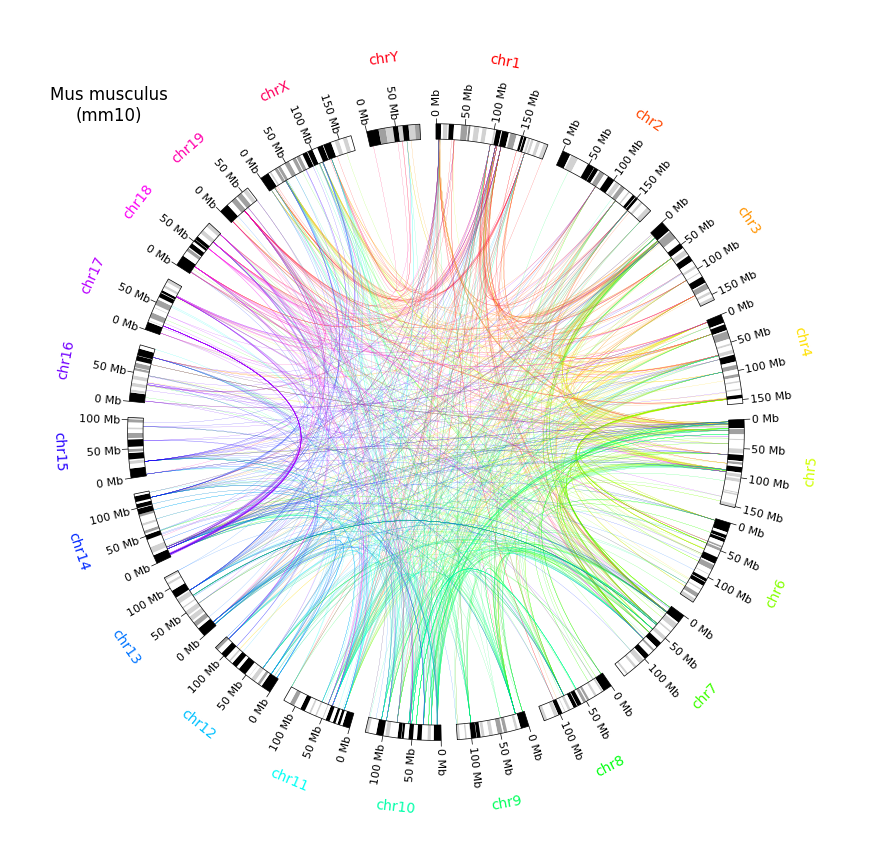

In [8]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10)
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("mm10")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Mus musculus\n(mm10)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color mapping
ColorCycler.set_cmap("hsv") 
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

# Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        50000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb",
    )

# Plot chromosome link
for link in chr_links:
    region1 = (link.query_chr, link.query_start, link.query_end)
    region2 = (link.ref_chr, link.ref_start, link.ref_end)
    color = chr_name2color[link.query_chr]
    if link.query_chr != link.ref_chr:
        circos.link(region1, region2, color=color)

fig = circos.plotfig()